# Задание 2

Подключаем необходимые библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import mlflow
from mlflow.models import infer_signature

Считываем данные и формируем dataset. Выводим для наглядности немного данных.

In [2]:
dataset = pd.read_csv('./dataset.csv')
dataset.head(10)

subject_id  Count_subj  study_id  cart_id  Healthy_Status eeg_time   \
0    19557662          27  40000017  6848296               0   8:44 AM   
1    18477137          93  40000029  6848296               0   9:54 AM   
2    16598616           3  40000035  6376932               1   9:07 AM   
3    16368287           7  40000079  6214760               1   5:14 PM   
4    18370366           2  40000084  6632385               0   1:52 PM   
5    15606157          55  40000089  6632385               0   2:29 PM   
6    12576058          43  40000115  6852956               1  12:54 PM   
7    14691089           1  40000143  6551957               0  10:01 AM   
8    14144725           7  40000144  6924910               0   7:24 AM   
9    16089780           2  40000152  6919786               0  12:35 PM   

    eeg_date                    report_0  \
0  27.06.2015               Sinus rhythm   
1  27.06.2015               Sinus rhythm   
2  28.06.2015          Sinus tachycardia   
3  15.07.2015               Sinus rhythm   
4  27.09.2015               Sinus rhythm   
5  29.10.2013               Sinus rhythm   
6  23.03.2016               Sinus rhythm   
7  10.12.2016               Sinus rhythm   
8  11.12.2011  Sinus rhythm with PAC(s).   
9  13.12.2011               Sinus rhythm   

                                            report_1  \
0                  Possible right atrial abnormality   
1                  Possible right atrial abnormality   
2                                                NaN   
3                                                NaN   
4                                                NaN   
5                                                NaN   
6                                                NaN   
7                 rSr'(V1) - probable normal variant   
8                                                NaN   
9  Extensive T wave changes may be due to myocard...   

                               report_2  ...                    filtering  \
0                                   NaN  ...  60 Hz notch Baseline filter   
1                                   NaN  ...  60 Hz notch Baseline filter   
2            Normal ECG except for rate  ...  60 Hz notch Baseline filter   
3                            Normal ECG  ...  60 Hz notch Baseline filter   
4                                   NaN  ...              <not specified>   
5                                   NaN  ...              <not specified>   
6                            Normal ECG  ...  60 Hz notch Baseline filter   
7  Low QRS voltages in precordial leads  ...  60 Hz notch Baseline filter   
8                        Borderline ECG  ...  60 Hz notch Baseline filter   
9                                   NaN  ...  60 Hz notch Baseline filter   

  rr_interval p_onset  p_end qrs_onset qrs_end t_end p_axis qrs_axis t_axis  
0         659      40    128       170     258   518     81       77     79  
1         722      40    124       162     246   504     77       75     70  
2         600      40    130       162     244   474     79       72     77  
3         659      40    146       180     254   538     79       66     69  
4         659     368  29999       504     590   868     84       80     77  
5         822     365  29999       499     592   852     26       46     30  
6         952      40    146       198     282   598     24       80     20  
7         923      40    140       188     278   594     26       86     13  
8         952      40    180       196     294   610     59      -17      3  
9        1000      40    156       178     274   584      8      -11     19  

[10 rows x 36 columns]

## Задание 1

Визуализируйте с помощью boxplot загруженные данные, опишите ваши мысли по данным.

In [3]:
# Визуализация распределения числовых признаков
def build_graph(table_data):
    n = table_data.shape[1]
    fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
    for i in range(n):
        plt.sca(ax[i])
        col = table_data.columns[i]
        ax[i].set_title(col)
        sns.boxplot(y=table_data.iloc[:,i], data=table_data, medianprops={'color': 'r', 'linewidth': 2})

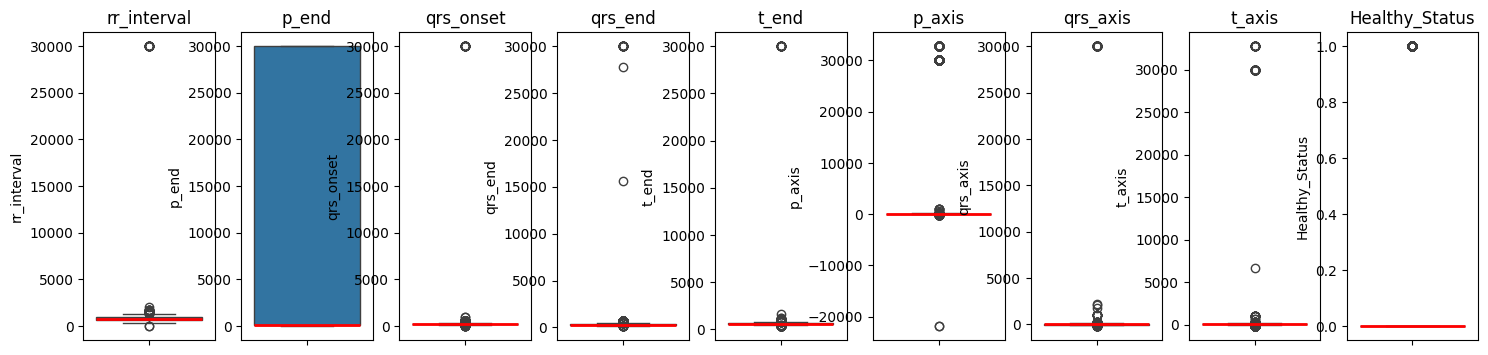

In [4]:
build_graph(dataset[['rr_interval','p_end','qrs_onset','qrs_end','t_end','p_axis','qrs_axis','t_axis','Healthy_Status']])

Как можно заметить, график является неинформативным, поскольку присутсвует большое количество выбросов, сильно отличающихся от основного множества значений

## Задание 2

Проанализируйте данные и  проведите их предобработку (очистку, обогащение).

In [5]:
# Предобрабатываем данные словестных репортов word2vec в числовой вектор

# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = dataset[(dataset[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[
    (full_df_filtered['p_onset'] < full_df_filtered['p_end']) & 
    (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])
]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = (
    full_df_filtered['report_0'].
    str.replace(r'\bnan\b', '', regex=True).
    str.replace(r'\s+', ' ', regex=True).str.strip()
)
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Фиксим имена столбцов
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})
full_df_filtered = full_df_filtered.drop(columns = ['bandwidth', 'filtering'])

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

# Разбиваем столбец с текстовым отчетом на токены
words = [text.split() for text in full_df_filtered['report']]

# Обучаем модель Word2Vec
w2v_model = Word2Vec(words)

# Функция для получения среднего эмбеддинга строки
def get_sentence_embedding(sentence):
    words = sentence.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Усреднённый вектор
    else:
        return np.zeros(w2v_model.vector_size)  # Нулевой вектор, если слова нет в модели

# Применяем функцию ко всей колонке и переводим каждый вектор в одно число
full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())

full_df_filtered.head()

subject_id  Count_subj  study_id  cart_id  eeg_time    eeg_date    report  \
0    19557662          27  40000017  6848296   8:44 AM  27.06.2015  0.042057   
1    18477137          93  40000029  6848296   9:54 AM  27.06.2015  0.042057   
2    16598616           3  40000035  6376932   9:07 AM  28.06.2015 -0.003423   
3    16368287           7  40000079  6214760   5:14 PM  15.07.2015  0.009583   
6    12576058          43  40000115  6852956  12:54 PM  23.03.2016  0.009583   

   rr_interval  p_onset  p_end  qrs_onset  qrs_end  t_end  p_axis  qrs_axis  \
0          659       40    128        170      258    518      81        77   
1          722       40    124        162      246    504      77        75   
2          600       40    130        162      244    474      79        72   
3          659       40    146        180      254    538      79        66   
6          952       40    146        198      282    598      24        80   

   t_axis  Healthy_Status  
0      79               0  
1      70               0  
2      77               1  
3      69               1  
6      20               1

## Задание 3

Сформируйте очищенный датасет, состоящий из числовых параметров ЭКГ и классификационного признака Healthy_Status, заново построить boxplot и сравните результаты с первоначальным.

In [6]:
table_data = full_df_filtered[['report','rr_interval','p_end','qrs_onset','qrs_end','t_end','p_axis','qrs_axis','t_axis','Healthy_Status']].copy()
table_data.head()

report  rr_interval  p_end  qrs_onset  qrs_end  t_end  p_axis  qrs_axis  \
0  0.042057          659    128        170      258    518      81        77   
1  0.042057          722    124        162      246    504      77        75   
2 -0.003423          600    130        162      244    474      79        72   
3  0.009583          659    146        180      254    538      79        66   
6  0.009583          952    146        198      282    598      24        80   

   t_axis  Healthy_Status  
0      79               0  
1      70               0  
2      77               1  
3      69               1  
6      20               1

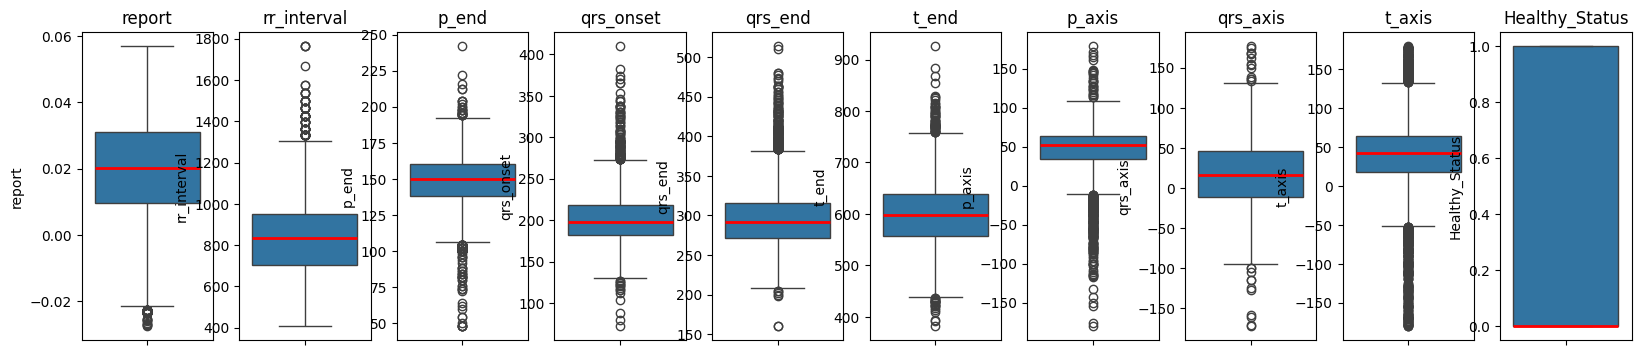

In [7]:
build_graph(table_data)

Как видно из графика, после исключения аномальных значений, он стал более наглядным и интепретируемым

## Задание 4

Проведите оценку взаимосвязи данных датасета с помощью функции heatmap.

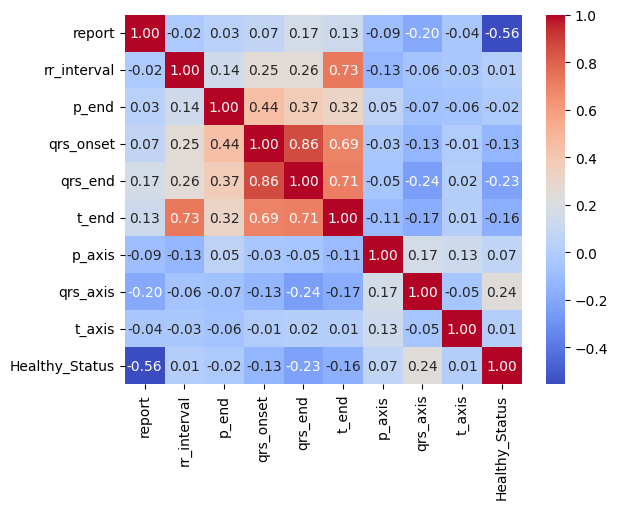

In [8]:
sns.heatmap(table_data.corr(),annot=True,fmt="0.2f",cmap="coolwarm")
plt.show()

По тепловой карте видно, что значения qrs_onset и qrs_end высоко коррелируются, что является логичным, так как они выражают начало и окончание одного процесса, также qrs_onset, qrs_end и rr_interval коррелируют с величиной t_end,

## Задание 5

На основе таргета (целевого признака) Healthy_Status построить корреляционную матрицу с помощью pairplot.

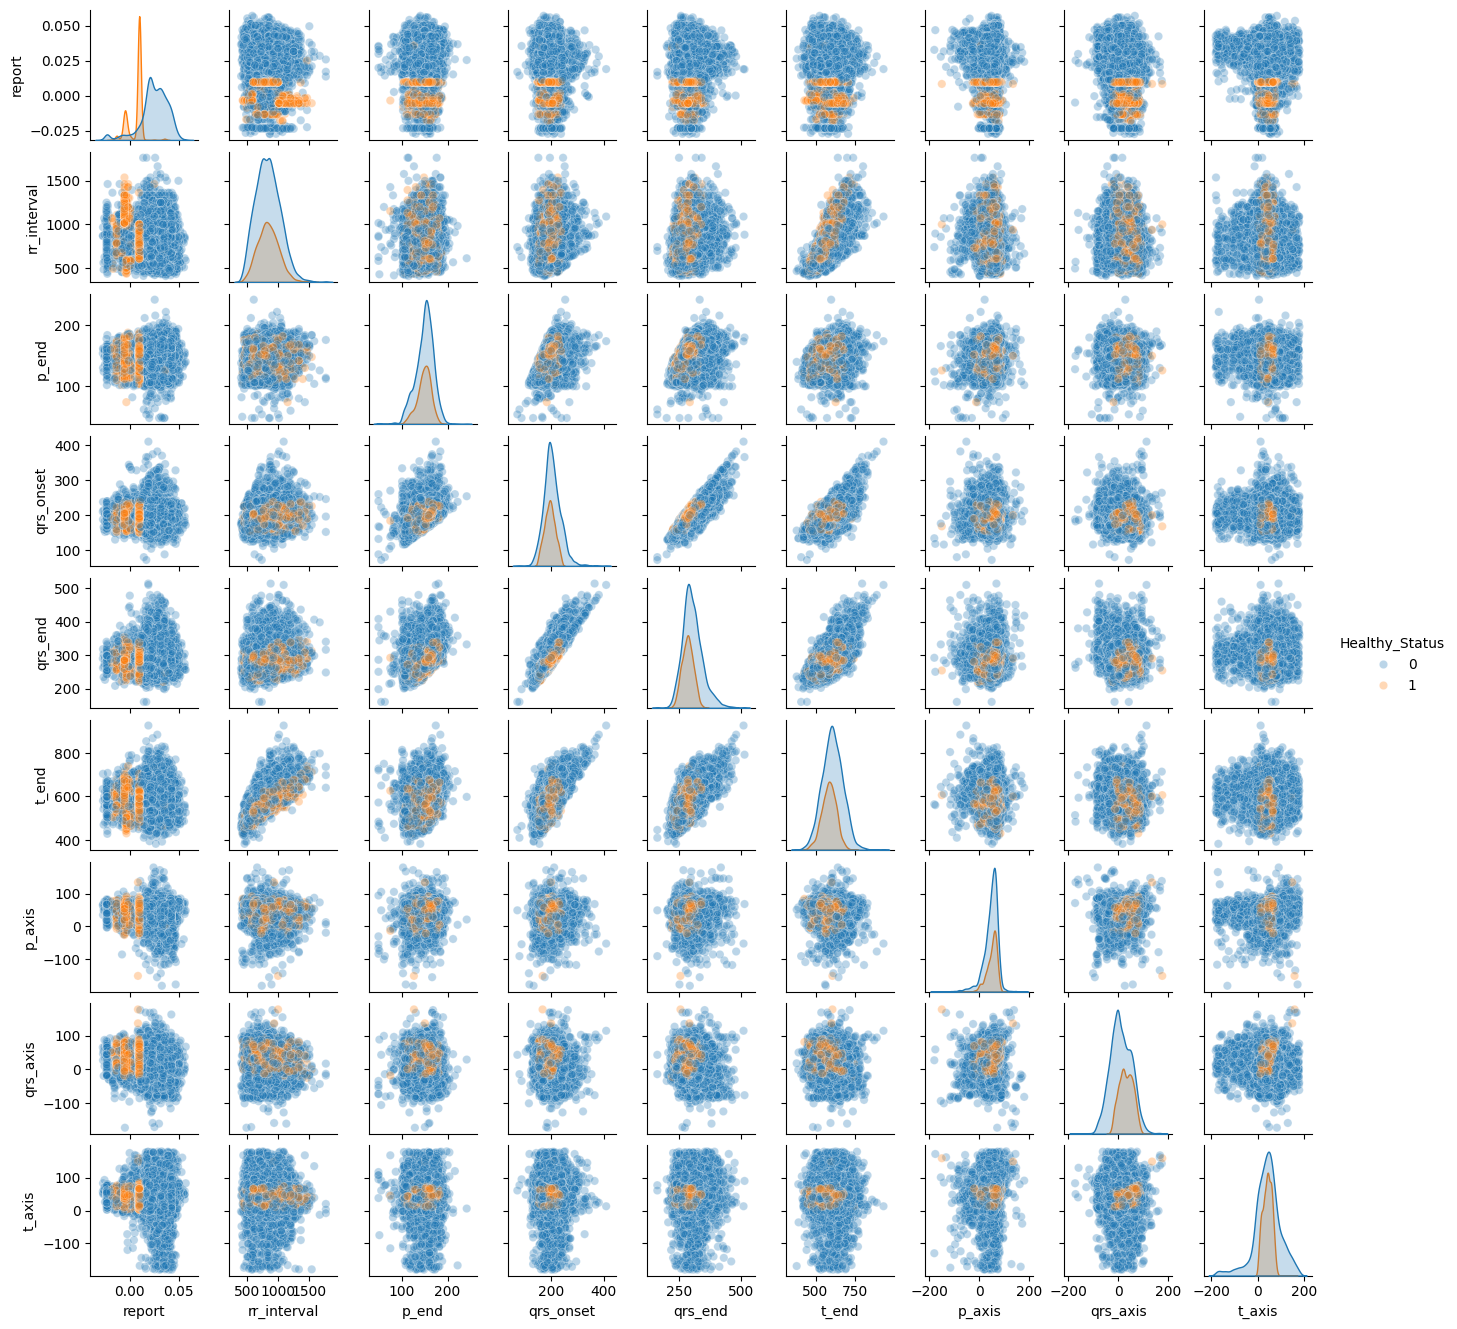

In [9]:
sns.pairplot(table_data, hue = "Healthy_Status",
             height=1.5,
             plot_kws=dict(alpha=0.3))

## Задание 6

Провести разведочный анализ данных с помощью метода PCA и с помощью TSNE.

### PCA

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [11]:
table_data_pca = table_data
table_data_pca = table_data_pca.drop('Healthy_Status', axis = 1)
table_data_pca.columns

Index(['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end',
       'p_axis', 'qrs_axis', 't_axis'],
      dtype='object')

In [12]:
scaled_data = StandardScaler().fit(table_data_pca).transform(table_data_pca)
pca = PCA(n_components = 2).fit(scaled_data)
x_pca = pca.transform(scaled_data)
print(table_data.shape, x_pca.shape)

(7046, 10) (7046, 2)


In [13]:
percent = pca.explained_variance_ratio_
print(percent)
print(sum(percent))

[0.34435346 0.14073499]
0.48508844985762445


In [14]:
def pca_explained(X, threshold):
  features = X.shape[1]
  for i in range(2, features):
    pca = PCA(n_components = i).fit(X)
    sum_ = pca.explained_variance_ratio_
    # add all components explained variances
    percent = sum(sum_)
    print('{} components at {:.2f}% explained variance'.format(i,percent*100))
    if percent > threshold:
      break

pca_explained(scaled_data, 0.85)

2 components at 48.51% explained variance
3 components at 61.27% explained variance
4 components at 72.79% explained variance
5 components at 82.00% explained variance
6 components at 90.10% explained variance


Text(0, 0.5, 'Second Principal Component')

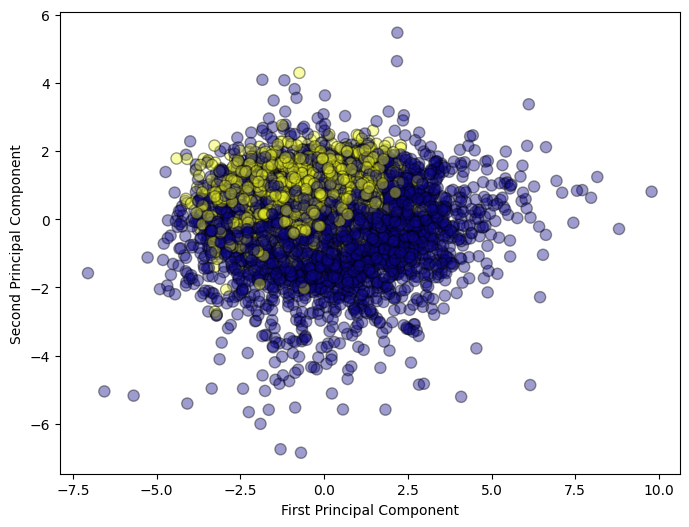

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

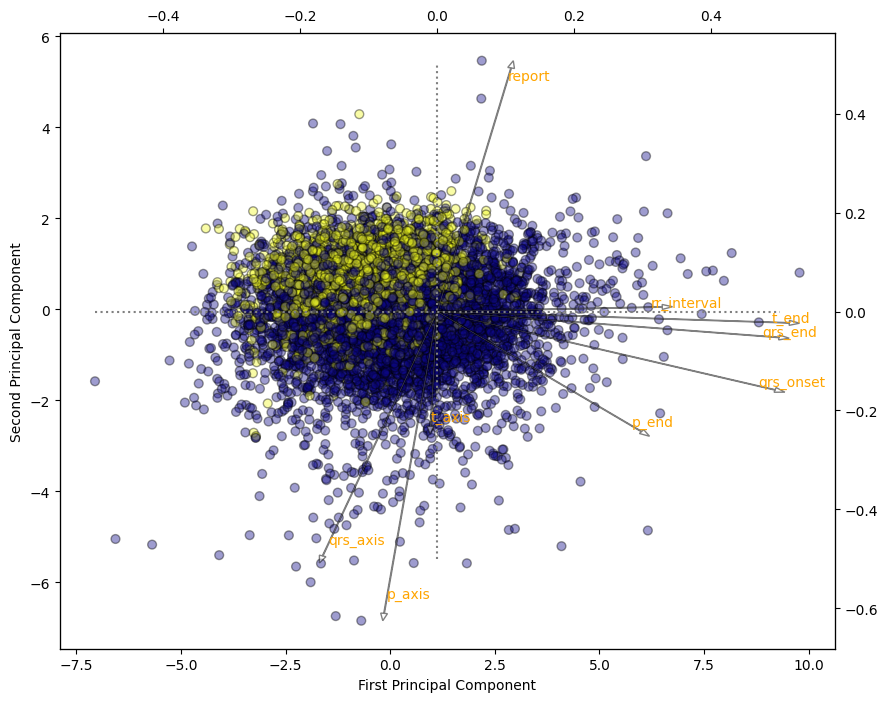

In [16]:
components = pd.DataFrame(pca.components_.T, index=table_data_pca.columns, columns= ['PCA1','PCA2'])

plt.figure(figsize=(10,8))

plt.scatter(x_pca[:,0], x_pca[:,1], c=full_df_filtered['Healthy_Status'],
            cmap='plasma', alpha=0.4, edgecolors='black', s=40);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

ax2 = plt.twinx().twiny();

ax2.hlines(0,-0.5,0.5, linestyles='dotted', colors='grey')
ax2.vlines(0,-0.5,0.5, linestyles='dotted', colors='grey')

offset = 0.95
for a, i in enumerate(components.index):
  ax2.arrow(0, 0, components['PCA1'][a], -components['PCA2'][a], alpha=0.5, facecolor='white', head_width=.01)
  ax2.annotate(i, (components['PCA1'][a]*offset, -components['PCA2'][a]*offset), color='orange')

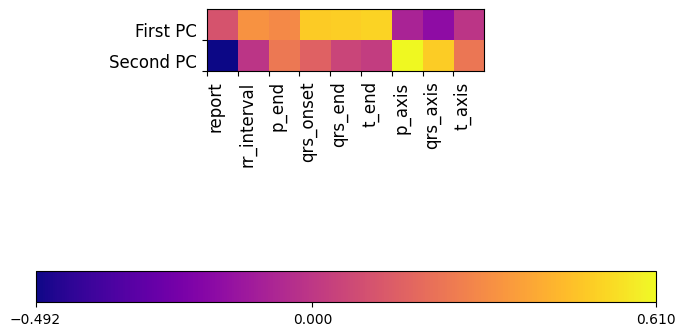

In [17]:
fig = plt.figure(figsize=(8, 4))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
feature_names = list(table_data_pca.columns)
plt.gca().set_xticks(np.arange(-.5, len(feature_names)-1));
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(feature_names, rotation=90, ha='left',fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom',fontsize=12);
plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0,
                                              pca.components_.max()],pad=0.65);

### TSNE

Text(0, 0.5, 'Second Principal Component')

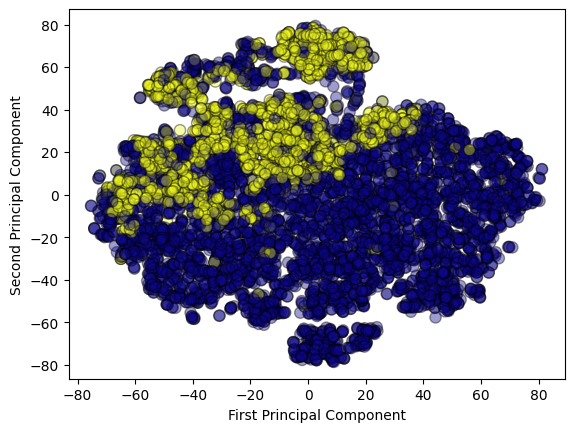

In [18]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0)
scaled_data_tsne = tsne.fit_transform(scaled_data)
plt.scatter(scaled_data_tsne[:,0], scaled_data_tsne[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

## Задание 7

Сделать вывод о структуре признаков данных

In [19]:
from sklearn import manifold
from time import time

Time code evaluation for perplexity=1 in 7.4 sec
Time code evaluation for perplexity=5 in 8 sec
Time code evaluation for perplexity=10 in 8.3 sec
Time code evaluation for perplexity=15 in 8.3 sec
Time code evaluation for perplexity=20 in 9 sec
Time code evaluation for perplexity=30 in 9.9 sec
Time code evaluation for perplexity=40 in 11 sec
Time code evaluation for perplexity=50 in 12 sec
Time code evaluation for perplexity=100 in 12 sec


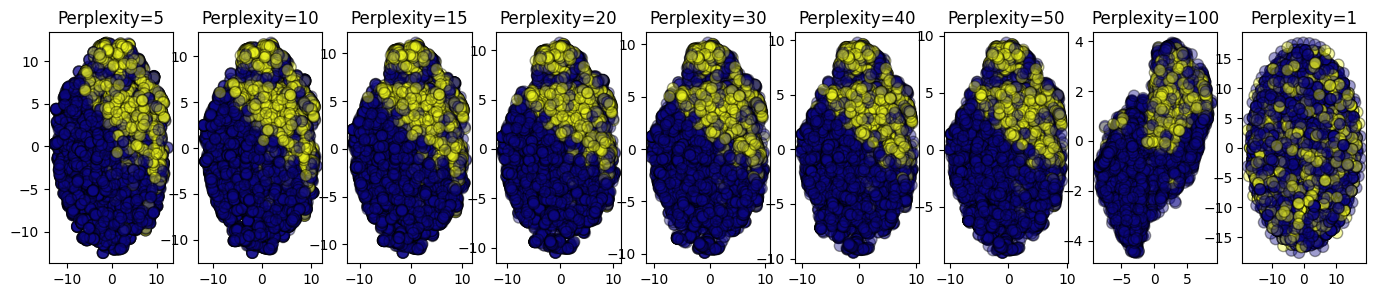

In [20]:
n_components = 2
perplexities = [1, 5, 10, 15, 20, 30, 40, 50, 100]

(fig, subplots) = plt.subplots(1, len(perplexities), figsize=(17, 3))

for i, perplexity in enumerate(perplexities):
    ax = subplots[i-1]

    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components,
        init="random",
        random_state=0,
        perplexity=perplexity,
        max_iter=300,
        )

    scaled_data_tsne = tsne.fit_transform(scaled_data)
    t1 = time()

    print("Time code evaluation for perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(scaled_data_tsne[:,0], scaled_data_tsne[:,1],
               c=full_df_filtered['Healthy_Status'],
               cmap='plasma',
               alpha=0.4,
               edgecolors='black',
               s=65
               );
    ax.axis("tight")

Методы PCA и TSNE демонстрируют разделение классов, визуализация показывает, что на начальных значениях perplexity результаты примерно одинаковы.

## Задание 8

Сделайте вывод о том какое из Auto ML решений с этой задачей справилось лучше

In [21]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
table_data.columns

Index(['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end',
       'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status'],
      dtype='object')

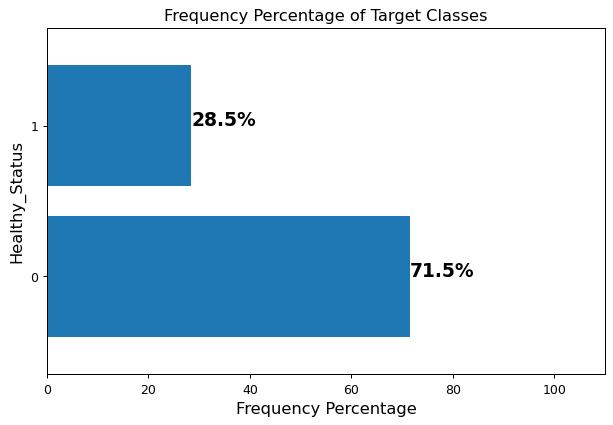

In [23]:
clf_index = 9
plt.figure(figsize=(35,20), dpi=90)
table_data[table_data.columns[clf_index]].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))

labels = table_data[table_data.columns[clf_index]].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=13)
plt.ylabel(table_data.columns[clf_index], fontsize=13)
plt.title('Frequency Percentage of Target Classes', fontsize=13)
plt.show()

Виден дисбаланс классов, избавимся от него с помощью метода SMOTE

In [24]:
from imblearn.over_sampling import SMOTE

In [25]:
target_column = 'Healthy_Status'

smote = SMOTE(random_state=0)
X_initial = table_data.drop(target_column, axis=1)
y_initial = table_data[target_column]

X, y = smote.fit_resample(X_initial, y_initial)

df = pd.DataFrame(X, columns=X_initial.columns)
df[target_column] = y

df[target_column].value_counts()

Healthy_Status
0    5039
1    5039
Name: count, dtype: int64

In [26]:
X = df.drop(df.columns[[clf_index]], axis=1).iloc[:,:]
y = pd.Series(LabelEncoder().fit_transform(df.iloc[:, clf_index]))

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=0, stratify=y.values)

Возьмем за базовую отметку результаты модели наивного гауссовского байесовского алгоритма

In [28]:
сlassifier = GaussianNB()
сlassifier.fit(X_train, y_train)

GaussianNB()

In [29]:
y_train__pred = сlassifier.predict(X_train)
y_test__pred = сlassifier.predict(X_test)

In [30]:
(f'Accuracy train data {accuracy_score(y_train, y_train__pred)}',
    f'Accuracy test data {accuracy_score(y_test, y_test__pred)}')

('Accuracy train data 0.8667422738871562',
 'Accuracy test data 0.8759920634920635')

In [31]:
(f'F1 score train data {f1_score(y_train, y_train__pred)}',
    f'F1 score test data {f1_score(y_test, y_test__pred)}')

('F1 score train data 0.8768666492009431',
 'F1 score test data 0.8847926267281107')

              precision    recall  f1-score   support

        True       0.94      0.80      0.87      1512
       False       0.83      0.95      0.88      1512

    accuracy                           0.88      3024
   macro avg       0.88      0.88      0.88      3024
weighted avg       0.88      0.88      0.88      3024



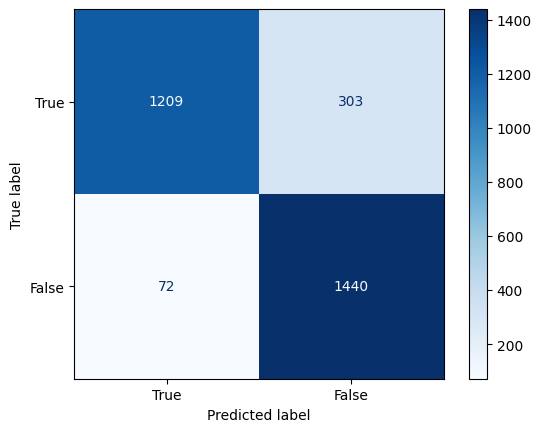

In [32]:
target_names = ['True', 'False']
labels_names = [0,1]
print(classification_report(y_test, y_test__pred, labels=labels_names, target_names=target_names))

cm = confusion_matrix(y_test, y_test__pred, labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

### AutoML LAMA

In [33]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


In [34]:
autoML_df = df[['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()

In [35]:
train_data, test_data = train_test_split(autoML_df, test_size=0.2, stratify=autoML_df['Healthy_Status'], random_state=42)

In [36]:
automl = TabularAutoML(
    task=Task('binary'),
    timeout=100,
    cpu_limit=4,
    reader_params={'n_jobs': 4, 'cv': 3, 'random_state': 42},
)

In [37]:
predictions = automl.fit_predict(train_data, roles={'target': 'Healthy_Status'}, verbose=0)

In [38]:
test_predictions = automl.predict(test_data).data

In [39]:
for i in range(len(test_predictions)):
    if test_predictions[i] > 0.5:
        test_predictions[i] = 1
    else:
        test_predictions[i] = 0

In [40]:
predictions_data = predictions.data
for i in range(len(predictions_data)):
    if predictions_data[i] > 0.5:
        predictions_data[i] = 1
    else:
        predictions_data[i] = 0

In [41]:
(f'Accuracy train data {accuracy_score(train_data["Healthy_Status"], predictions_data)}',
    f'Accuracy test data {accuracy_score(test_data["Healthy_Status"], test_predictions)}')

('Accuracy train data 0.9847432398908459',
 'Accuracy test data 0.9846230158730159')

In [42]:
(f'F1 score train data {f1_score(train_data["Healthy_Status"], predictions_data)}',
    f'F1 score test data {f1_score(test_data["Healthy_Status"], test_predictions)}')

('F1 score train data 0.9847337718753879',
 'F1 score test data 0.98456943753111')

              precision    recall  f1-score   support

        True       0.98      0.99      0.98      1008
       False       0.99      0.98      0.98      1008

    accuracy                           0.98      2016
   macro avg       0.98      0.98      0.98      2016
weighted avg       0.98      0.98      0.98      2016



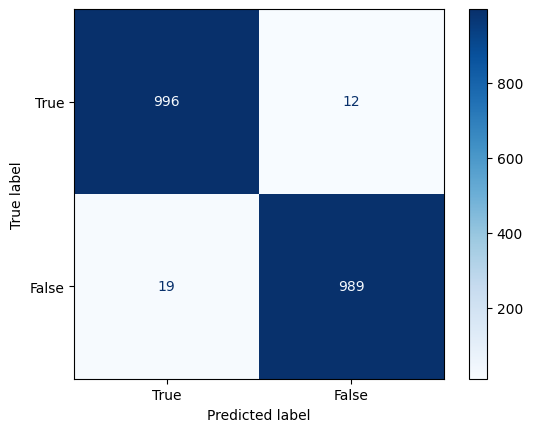

In [43]:
target_names = ['True', 'False']
labels_names = [0, 1]
print(classification_report(test_data['Healthy_Status'], test_predictions, labels=labels_names, target_names=target_names))

cm = confusion_matrix(test_data['Healthy_Status'], test_predictions, labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [44]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.94427 * (3 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.05573 * (3 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 


In [45]:
algo = automl.levels[0][0].ml_algos[0]
model = algo.models[0]
print(f'Алгоритм - {type(algo).__name__}\nМодель - {type(model).__name__}\n')

Алгоритм - BoostLGBM
Модель - Booster



In [46]:
with open(f'./lightautoml_electrocardiogram_m2_model.pkl', 'wb') as f:
    pickle.dump(automl, f)

In [47]:
mlflow.set_tracking_uri(uri='http://127.0.0.1:8080')
mlflow.set_experiment('Task 2')

<Experiment: artifact_location='/home/user/artifacts/1', creation_time=1744300024248, experiment_id='1', last_update_time=1744300024248, lifecycle_stage='active', name='Task 2', tags={}>

In [48]:
with mlflow.start_run(run_name='LAMA'):
    mlflow.log_params(
        {
            'n_jobs': 4, 
            'cv': 3, 
            'random_state': 42,
            'timeout': 100,
            'cpu_limit': 4,
            'algoritm': algo,
            'model': model
        }
    )
    mlflow.log_metrics(
        {
            'Accuracy train data': accuracy_score(train_data['Healthy_Status'], predictions_data),
            'Accuracy test data': accuracy_score(test_data["Healthy_Status"], test_predictions),
            'F1 score train data': f1_score(train_data["Healthy_Status"], predictions_data),
            'F1 score test data': f1_score(test_data["Healthy_Status"], test_predictions),
        }
    )
    mlflow.log_artifact('./lightautoml_electrocardiogram_m2_model.pkl')
    
    model_info = mlflow.sklearn.log_model(
        sk_model=automl,
        artifact_path='lama_model',
        signature=infer_signature(train_data, predictions_data),
        input_example=train_data,
    )

2025/04/10 22:57:03 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



🏃 View run LAMA at: http://127.0.0.1:8080/#/experiments/1/runs/409a69208e034ac9b3c68e46e11af496
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


### AutoML Fedot

2025-04-10 22:57:16,311 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-04-10 22:57:19,350 - ApiComposer - Initial pipeline was fitted in 3.0 sec.
2025-04-10 22:57:19,352 - ApiComposer - Taking into account n_folds=5, estimated fit time for initial assumption is 15.0 sec.
2025-04-10 22:57:19,354 - AssumptionsHandler - Preset was changed to fast_train due to fit time estimation for initial model.
2025-04-10 22:57:19,369 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 3 min. Set of candidate models: ['bernb', 'dt', 'knn', 'logit', 'normalization', 'pca', 'qda', 'rf', 'scaling'].
2025-04-10 22:57:19,535 - ApiComposer - Timeout is too small for composing and is skipped because fit_time is 14.98868 sec.
2025-04-10 22:57:19,667 - ApiComposer - Hyperparameters tuning started with 3 min. timeout
2025-04-10 22:57:33,614 

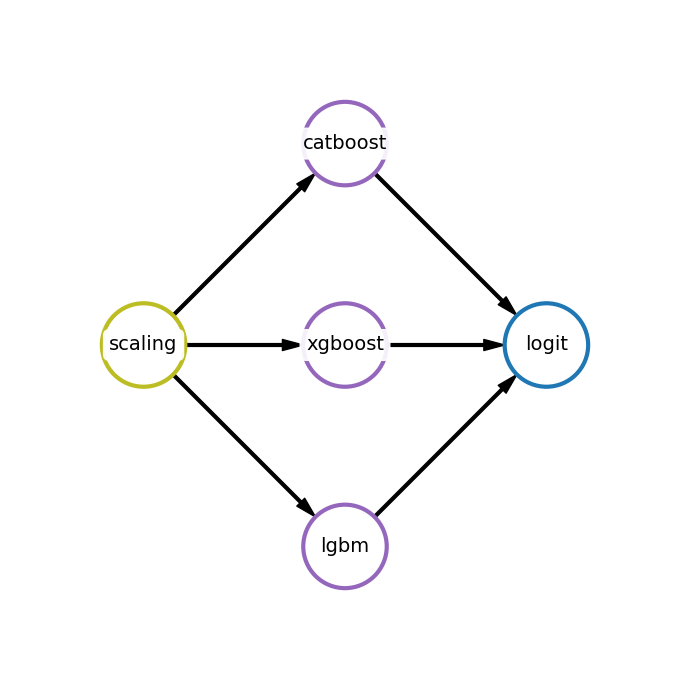

In [49]:
from fedot.api.main import Fedot
fedot_model = Fedot(problem='classification', timeout=3)
obtained_pipeline = fedot_model.fit(features=X_train, target=y_train)
obtained_pipeline.show()

In [50]:
y_train__predict = fedot_model.predict(X_train)
y_test__predict = fedot_model.predict(X_test)

In [51]:
(f'Accuracy train data {accuracy_score(y_train, y_train__predict)}',
    f'Accuracy test data {accuracy_score(y_test, y_test__predict)}')

('Accuracy train data 0.994754749078537',
 'Accuracy test data 0.9798280423280423')

In [52]:
(f'F1 score train data {f1_score(y_train, y_train__predict)}',
    f'F1 score test data {f1_score(y_test, y_test__predict)}')

('F1 score train data 0.994762915782024',
 'F1 score test data 0.9799011532125206')

              precision    recall  f1-score   support

        True       0.98      0.98      0.98      1512
       False       0.98      0.98      0.98      1512

    accuracy                           0.98      3024
   macro avg       0.98      0.98      0.98      3024
weighted avg       0.98      0.98      0.98      3024



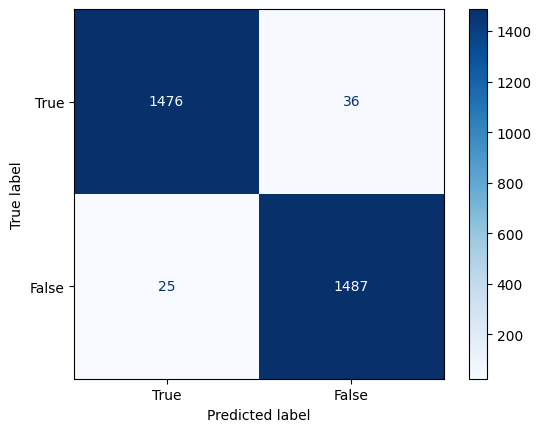

In [53]:
target_names = ['True', 'False']
labels_names = [0,1]
print(classification_report(y_test, y_test__predict, labels=labels_names, target_names=target_names))

cm = confusion_matrix(y_test, y_test__predict, labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [54]:
fedot_model.current_pipeline

{'depth': 3, 'length': 5, 'nodes': [logit, catboost, scaling, xgboost, lgbm]}

In [55]:
with open(f'./fedot_model_task2.pkl', 'wb') as f:
    pickle.dump(fedot_model, f)

In [56]:
with mlflow.start_run(run_name='FEDOT'):
    mlflow.log_params(
        {
            'problem':'classification',
            'timeout': 3,
        }
    )
    mlflow.log_metrics(
        {
            'Accuracy train data': accuracy_score(y_train, y_train__predict),
            'Accuracy test data': accuracy_score(y_test, y_test__predict),
            'F1 score train data': f1_score(y_train, y_train__predict),
            'F1 score test data': f1_score(y_test, y_test__predict)
        }
    )
    mlflow.log_artifact('./fedot_model_task2.pkl')
    
    model_info = mlflow.sklearn.log_model(
        sk_model=fedot_model,
        artifact_path='model_fedot',
        signature=infer_signature(X_train, y_train__predict),
        input_example=X_train,
    )

🏃 View run FEDOT at: http://127.0.0.1:8080/#/experiments/1/runs/ca226e0336a740aeb5c3de2a44a19396
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


### AutoML H2O

In [69]:
import h2o
from h2o.automl import H2OAutoML
import mlflow
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, f1_score, 
                           classification_report, 
                           confusion_matrix, ConfusionMatrixDisplay)
import pickle

In [70]:
# Инициализация H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /home/user/myenv/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpzsoyy8_g
  JVM stdout: /tmp/tmpzsoyy8_g/h2o_user_started_from_python.out
  JVM stderr: /tmp/tmpzsoyy8_g/h2o_user_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------
H2O_cluster_uptime:         01 secs
H2O_cluster_timezone:       Europe/Moscow
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    14 days and 7 hours
H2O_cluster_name:           H2O_from_python_user_prgwzp
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    2.707 Gb
H2O_cluster_total_cores:    6
H2O_cluster_allowed_cores:  6
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------

In [71]:
# Подготовка данных
hf = h2o.H2OFrame(df)
hf['Healthy_Status'] = hf['Healthy_Status'].asfactor()  # Для классификации

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [72]:
# Разделение данных
train, test = hf.split_frame(ratios=[0.7], seed=200)
x = hf.columns
x.remove('Healthy_Status')
y = 'Healthy_Status'

In [73]:
# Обучение модели (эквивалент 5 минут в TPOT)
aml = H2OAutoML(
    max_runtime_secs=300,  # 5 минут
    seed=42,
    verbosity='info',
    exclude_algos=["DeepLearning", "StackedEnsemble"]  # Для простоты
)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |
23:00:41.395: Project: AutoML_1_20250410_230041
23:00:41.398: 5-fold cross-validation will be used.
23:00:41.398: Setting stopping tolerance adaptively based on the training frame: 0.01188792585913685
23:00:41.398: Build control seed: 42
23:00:41.402: training frame: Frame key: AutoML_1_20250410_230041_training_py_3_sid_b7de    cols: 10    rows: 7076  chunks: 1    size: 164867  checksum: 4827922876762345943
23:00:41.402: validation frame: NULL
23:00:41.402: leaderboard frame: NULL
23:00:41.402: blending frame: NULL
23:00:41.403: response column: Healthy_Status
23:00:41.403: fold column: null
23:00:41.403: weights column: null
23:00:41.424: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (6g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), grid_1 (4g, 60w), lr_annealing (6g, 10w)]

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20250410_230041_model_11


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    89                 89                          313314                 17           17           17            177           354           275.854

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0001608780880020966
RMSE: 0.012683772624976237
LogLoss: 0.004248773873793211
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.7432237504734436
       0     1     Error    Rate
-----  ----  ----  -------  ------------
0      3539  0     0        (0.0/3539.0)
1      0     3537  0        (0.0/3537.0)
Total  3539  3537  0        (0.0/7076.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.743224     1         190
max f2                       0.743224     1         190
max f0point5                 0.743224     1         190
max accuracy                 0.743224     1         190
max precision                0.999662     1         0
max recall                   0.743224     1         190
max specificity              0.999662     1         0
max absolute_mcc             0.743224     1         190
max min_per_class_accuracy   0.743224     1         190
max mean_per_class_accuracy  0.743224     1         190
max tns                      0.999662     3539      0
max fns                      0.999662     3521      0
max fps                      9.1084e-05   3539      399
max tps                      0.743224     3537      190
max tnr                      0.999662     1         0
max fnr                      0.999662     0.995476  0
max fpr                      9.1084e-05   1         399
max tpr                      0.743224     1         190

Gains/Lift Table: Avg response rate: 49.99 %, avg score: 50.00 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0100339                   0.999554           2.00057  2.00057            1                0.999601     1                           0.999601            0.0200735       0.0200735                  100.057  100.057            0.0200735
2        0.0200678                   0.999496           2.00057  2.00057            1                0.999526     1                           0.999564            0.0200735       0.040147                   100.057  100.057            0.040147
3        0.0301018                   0.999451           2.00057  2.00057            1                0.999473     1                           0.999534            0.0200735       0.0602205                  100.057  100.057            0.0602205
4        0.0401357                   0.999423           2.00057  2.00057            1                0.999437     1                           0.999509            0.0200735       0.080294                   100.057  100.057            0.080294
5        0.0500283                   0.999384           2.00057  2.00057            1                0.999403     1                           0.999488            0.0197908       0.100085          

In [74]:
# Получение лучшей модели
best_model = aml.leader

In [75]:
# Предсказания
train_pred = best_model.predict(train)['predict'].as_data_frame().values.ravel()
test_pred = best_model.predict(test)['predict'].as_data_frame().values.ravel()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

/home/user/myenv/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


/home/user/myenv/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [76]:
# Метрики
y_train_true = train['Healthy_Status'].as_data_frame().values.ravel()
y_test_true = test['Healthy_Status'].as_data_frame().values.ravel()

/home/user/myenv/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/user/myenv/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [77]:
(f'Accuracy train data {accuracy_score(y_train_true, train_pred)}',
    f'Accuracy test data {accuracy_score(y_test_true, test_pred)}')

('Accuracy train data 1.0', 'Accuracy test data 0.9806795469686875')

In [78]:
(f'F1 score train data {f1_score(y_train_true, train_pred)}',
    f'F1 score test data {f1_score(y_test_true, test_pred)}')

('F1 score train data 1.0', 'F1 score test data 0.980718085106383')

In [79]:
# Classification report
target_names = ['True', 'False']
labels_names = [0, 1]
print(classification_report(y_test_true, test_pred, 
                          labels=labels_names, 
                          target_names=target_names))

              precision    recall  f1-score   support

        True       0.98      0.98      0.98      1500
       False       0.98      0.98      0.98      1502

    accuracy                           0.98      3002
   macro avg       0.98      0.98      0.98      3002
weighted avg       0.98      0.98      0.98      3002



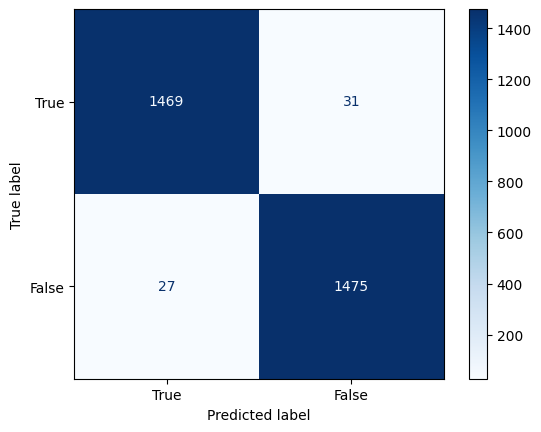

In [80]:
# Confusion matrix
cm = confusion_matrix(y_test_true, test_pred, labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                            display_labels=target_names)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [81]:
# Сохранение модели
model_path = h2o.save_model(best_model, path="./", force=True)

In [82]:
# Логирование в MLflow
with mlflow.start_run(run_name='H2O_AutoML'):
    # Параметры
    mlflow.log_params({
        'max_runtime_secs': 300,
        'seed': 42,
        'algorithm': best_model.algo
    })
    
    # Метрики
    mlflow.log_metrics({
        'Accuracy_train': accuracy_score(y_train_true, train_pred),
        'Accuracy_test': accuracy_score(y_test_true, test_pred),
        'F1_train': f1_score(y_train_true, train_pred),
        'F1_test': f1_score(y_test_true, test_pred)
    })
    
    # Артефакты
    mlflow.log_artifact(model_path)
    
    # Логирование модели H2O
    mlflow.h2o.log_model(
        h2o_model=best_model,
        artifact_path='h2o_model',
        registered_model_name='H2O_AutoML_Model'
    )

2025/04/10 23:05:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'H2O_AutoML_Model'.
2025/04/10 23:05:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: H2O_AutoML_Model, version 1


🏃 View run H2O_AutoML at: http://127.0.0.1:8080/#/experiments/1/runs/4306501fd6dd451da8acdf5a106413f4
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


Created version '1' of model 'H2O_AutoML_Model'.


In [83]:
# Завершение работы H2O
h2o.cluster().shutdown()

H2O session _sid_b7de closed.
